**Author:** Beatrice Occhiena s314971. See [`LICENSE`](https://github.com/beatrice-occhiena/Computational_intelligence/blob/main/LICENSE) for details.
- institutional email: `S314971@studenti.polito.it`
- personal email: `beatrice.occhiena@live.it`
- github repository: [https://github.com/beatrice-occhiena/Computational_intelligence.git](https://github.com/beatrice-occhiena/Computational_intelligence.git)

**Resources:** These notes are the result of additional research and analysis of the lecture material presented by Professor Giovanni Squillero for the Computational Intelligence course during the academic year 2023-2024 @ Politecnico di Torino. They are intended to be my attempt to make a personal contribution and to rework the topics covered in the following resources.
- [https://github.com/squillero/computational-intelligence](https://github.com/squillero/computational-intelligence)
- Stuart Russel, Peter Norvig, *Artificial Intelligence: A Modern Approach* [3th edition]
- Richard S. Sutton, Andrew G. Barto, *Reinforcement Learning: An Introduction* [2nd Edition]
- Useful site to better understand Monte Carlo method [analyticsvidhya.com](https://www.analyticsvidhya.com/blog/2018/11/reinforcement-learning-introduction-monte-carlo-learning-openai-gym/)
- I got the Magic Square idea from [https://github.com/squillero/computational-intelligence/blob/master/2023-24/lab10-gx.ipynb](https://github.com/squillero/computational-intelligence/blob/master/2023-24/lab10-gx.ipynb)
- I really liked and therefore adopted the code organization from [Davide Sferrazza's s326619 repository](https://github.com/FarInHeight/Computational-Intelligence)

.

.

# Lab 10: Reinforcement Learning
**MAIN TASK**: Use reinforcement learning to devise a tic-tac-toe player.
- `Deadline`: Christmas Day 🎅🏻
- `Reviews`: Epiphany 📆

In [3]:
from itertools import combinations
from collections import namedtuple, defaultdict
from random import choice, random
from copy import deepcopy

from tqdm.auto import tqdm
import numpy as np
import matplotlib.pyplot as plt

## [1] Tic-Tac-Toe Game Environment

### Game Class

#### Magic Square Trick

A magic square, in the context of this game, is a specific arrangement of numbers that plays a crucial role in simplifying the win condition check. In a standard 3x3 magic square, each cell contains a unique number from 1 to 9, and the sum of the numbers in any row, column, or diagonal is always the same.

`MAGIC = [2, 7, 6, 9, 5, 1, 4, 3, 8]`

- **Efficient win check**: In Tic-Tac-Toe, a player wins if they can line up three of their marks (either X or O) in a row, column, or diagonal. By using a magic square, if the sum of the magic square numbers corresponding to a player's marks is `15`, then that player has achieved a winning combination

In [4]:
class TicTacToe:
  def __init__(self, starting_player='X'):
    # Initialize the empty board
    self.board = [[' ' for _ in range(3)] for _ in range(3)]
    # Define magic square to check for a winner
    self.magic_square = [[2, 7, 6], [9, 5, 1], [4, 3, 8]]
    # Define player symbols
    self.players = ['X', 'O']
    # Initialize the current player
    self.current_player = starting_player

  def print_board(self):
    """Display the current state of the board"""
    emoji_map = {'X': '❌', 'O': '🔘', ' ': '⬜'}
    for row in self.board:
      print(''.join([emoji_map[space] for space in row]))
    print()

  def make_move(self, row, col):
    """Make a move on the board if the space is empty"""
    if self.board[row][col] == ' ' and 0 <= row <= 2 and 0 <= col <= 2:
      self.board[row][col] = self.current_player
      return True # Move was successful
    else:
      print("Invalid move!")
      return False # Move was unsuccessful
    
  def switch_player(self):
    """Switch the current player"""
    self.current_player = self.players[(self.players.index(self.current_player) + 1) % 2]

  def check_winner(self):
    """
    Check if there is a winner on the board.
    - Returns 'X' if X wins
    - Returns 'O' if O wins
    - Returns None if there is no winner
    """
    # 1. Convert board positions to magic square values
    x_positions = [self.magic_square[row][col] for row in range(3) for col in range(3) if self.board[row][col] == 'X']
    o_positions = [self.magic_square[row][col] for row in range(3) for col in range(3) if self.board[row][col] == 'O']
    
    # 2. Check if any combination of 3 positions sums to 15
    if any(sum(comb) == 15 for comb in combinations(x_positions, 3)):
      return 'X'
    elif any(sum(comb) == 15 for comb in combinations(o_positions, 3)):
      return 'O'

    return None
  
  def is_draw(self):
    """Check if the game is a draw"""
    return all([space != ' ' for row in self.board for space in row])

### Player Class

In [5]:
class Player:
  def __init__(self):
    pass

  def make_move(self, game: TicTacToe):
    """Make a move in the given TicTacToe game instance"""
    raise NotImplementedError("This method should be implemented by subclasses.")

In [6]:
class HumanPlayer(Player):
  
  def make_move(self, game: TicTacToe):
    """Get a move from the user"""

    # 1. Print the board
    print("Current board:")
    game.print_board()

    # 2. Get a valid move from the user
    valid_move = False
    while not valid_move:
      try:
        row = int(input("Enter row (0-2): "))
        col = int(input("Enter column (0-2): "))
        valid_move = game.make_move(row, col)
        if not valid_move:
          print("Invalid move, try again.")
      except ValueError:
        print("Invalid input. Please enter numbers only.")

In [11]:
class RandomPlayer(Player):
    
  def make_move(self, game: TicTacToe):
    """Make a random move on the board"""
    # 1. Get all empty spaces
    empty_spaces = [(row, col) for row in range(3) for col in range(3) if game.board[row][col] == ' ']
    # 2. Choose a random empty space
    row, col = choice(empty_spaces)
    # 3. Make the move
    game.make_move(row, col)

### Match Implementation

In [7]:
def play_game(game: TicTacToe, player1: Player, player2: Player, verbose=False) -> str:
  
  """
    Play a game of TicTacToe between two players
    - player1 as 'X': The first player to make a move
    - player2 as 'O': The second player to make a move
    
    Returns the winner of the game
  """
  
  # 1. Initialize the game
  game_over = False
  winner = None

  # 2. Play the game
  while not game_over:
    # 2.1. Get the current player
    current_player = player1 if game.current_player == 'X' else player2

    # 2.2. VERBOSE: Print the board
    if verbose:
      print(f"Current player: {game.current_player}")
      game.print_board()

    # 2.3. Make a move
    current_player.make_move(game)

    # 2.4. Check if the game is over
    winner = game.check_winner()
    if winner is not None:
      game_over = True
    elif game.is_draw():
      game_over = True

    # 2.5. Switch the player
    game.switch_player()

  # 3. VERBOSE: Print the final board
  if verbose:
    print("Final board:")
    game.print_board()

  # 4. VERBOSE: Print the winner
  if winner is None:
    if verbose:
      print("It's a draw!")
    return 'draw'
  else:
    if verbose:
      print(f"{winner} wins!")
    return winner

In [8]:
def collect_results(player1: Player, player2: Player, n_games=1000, verbose=False):
  """
    Play n_games of TicTacToe between two players and return the results
    - player1 as 'X': The first player to make a move
    - player2 as 'O': The second player to make a move
  """
  # 1. Initialize the results
  results = defaultdict(int)

  # 2. Play the games
  # tqdm is a progress bar that displays the progress of the loop
  for _ in tqdm(range(n_games)):
    new_game = TicTacToe()
    winner = play_game(new_game, deepcopy(player1), deepcopy(player2), verbose=verbose)
    results[winner] += 1

  # 3. Print the results
  print(f"Player 1 ({player1.__class__.__name__}) wins: {results['X']}")
  print(f"Player 2 ({player2.__class__.__name__}) wins: {results['O']}")
  print(f"Draws: {results['draw']}")

  return results

#### Example matches
Here are some examples of matches between two random players to check the correct implementation of the game mechanics and the results collection.

Current player: X
⬜⬜⬜
⬜⬜⬜
⬜⬜⬜

Current player: O
⬜⬜⬜
⬜⬜⬜
⬜⬜❌

Current player: X
⬜⬜⬜
⬜⬜🔘
⬜⬜❌

Current player: O
⬜⬜⬜
⬜⬜🔘
⬜❌❌

Current player: X
⬜⬜🔘
⬜⬜🔘
⬜❌❌

Final board:
⬜⬜🔘
⬜⬜🔘
❌❌❌

X wins!


100%|██████████| 1000/1000 [00:00<00:00, 9243.44it/s]

Player 1 (RandomPlayer) wins: 585
Player 2 (RandomPlayer) wins: 308
Draws: 107


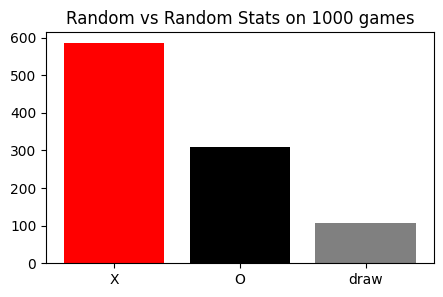

<Figure size 500x500 with 0 Axes>

In [84]:
# 1. Initialize the players
rand_player1 = RandomPlayer()
rand_player2 = RandomPlayer()

# 2. Play one game with verbose output
new_game = TicTacToe()
play_game(new_game, rand_player1, rand_player2, verbose=True)

# 3. Play multiple games to collect the statistics
results = collect_results(rand_player1, rand_player2, n_games=1000, verbose=False)

# 4. Plot the results
plt.title("Random vs Random Stats on 1000 games")
plt.bar(range(3), [results['X'], results['O'], results['draw']], color=['red', 'black', 'gray'])
plt.xticks(range(3), ['X', 'O', 'draw'])
plt.figure(figsize=(5, 5))
plt.show()

## [2] Reinforcement Learning

### Monte Carlo Method 🤹🏻

The fundamental idea underlying the Monte Carlo method is to use simulations to solve problems that cannot be easily solved analytically.
- **Model-Free**: Unlike other techniques, here we do not assume complete knowledge of the environment's dynamics. Monte Carlo methods require only `experience`, since it addresses uncertainty by `simulating` different possible sequences of events, often referred to as `trajectories`. This makes them particularly useful in situations where model information is difficult to obtain or unavailable.
- **Average Return**: For each sampled trajectory, the method observes the returns obtained by the agent. Returns represent the `cumulative rewards` obtained over the entire sequence of actions. Since different trajectories may result in different returns due to the `stochastic nature` of the environment, the method averages these returns over multiple samples.

  > Action-value function: $Q(s,a) = \frac{1}{N} \sum_{i=1}^{N} G_i(s,a)$
  
  Where $G_i(s,a)$ is the return obtained by the agent after performing action $a$ in state $s$ in the $i$-th sampled trajectory.

The Monte Carlo method is particularly well-suited in this context due to the following reasons:
1. **Limited State Space**: Tic-tac-toe has a finite and relatively small state space, making it feasible for the Monte Carlo method to explore and evaluate all possible states through random sampling. In fact, the more simulations we run, the more accurate our estimates will be. But of course, this comes at the cost of `computational complexity`.
2. **Episodic Nature**: Tic-tac-toe is an episodic task, meaning that each episode (the match) has a well-defined terminal state (win, lose, or draw). This allows us to use the `terminal reward` as a proxy for the value of all states visited in that episode. This approach contrasts with methods that update values or policies at each step within an episode and may result in a form of `delayed learning`, slowing down the adaptation process. However, this is not a problem in our case, since the game has very short trajectories.


#### Parameters
- **Exploration Rate**: $\epsilon$ represents the probability of choosing to explore the environment rather than exploit the current known information. In other words, it's the likelihood that the learning agent will make a random move instead of the move that seems best according to its current knowledge.
- **Discount Factor**: $\gamma$  is a number between 0 and 1 that represents the importance of future rewards compared to immediate rewards. A higher value places more emphasis on future rewards, while a lower value makes the agent more short-sighted, caring more about immediate rewards. In the Monte Carlo method, after each game, we want to update the value of each state encountered during the match. The reward that a state receives depends not only on the immediate reward but also on the rewards of all future states, discounted by this factor. 
  > State value update: $V(s) = V(s) + \alpha [G_t - V(s)]$
  
  > Return from state $s$ onward: $G_t = R_{t+1} + \gamma R_{t+2} + \gamma^2 R_{t+3} + ... = \sum_{k=0}^{\infty} \gamma^k R_{t+k+1}$
- **Learning Rate**: $\alpha$ is the learning rate, which determines the extent to which new information overrides old information. A higher value makes the agent more sensitive to new information, while a lower value makes it more conservative, relying more on past experience.
  

In [89]:
class MonteCarloPlayer(Player):
    def __init__(self, exploration_rate=1, discount_factor=0.9, learning_rate=1, exploration_decay=0.999):
        super().__init__()

        # Parameters
        self.exploration_rate = exploration_rate
        self.discount_factor = discount_factor
        self.learning_rate = learning_rate
        self.exploration_decay = exploration_decay

        # Structures
        self.q_values = {} # Q(s, a)
        self.q_counters = {} # N(s, a)

    def get_hashable_state(self, game: TicTacToe):
        """Get a hashable representation of the game state"""
        return tuple([tuple(row) for row in game.board])
    
    def get_action(self, game: TicTacToe, training_phase=False):
        """Get a new action for the state balancing exploration and exploitation"""

        # 0. Get the current state representation
        state = self.get_hashable_state(game)

        # 1. Get all possible actions
        empty_spaces = [(row, col) for row in range(3) for col in range(3) if game.board[row][col] == ' ']

        # 2. Explore: Choose a random action (only during training phase)
        if training_phase and random() < self.exploration_rate:
            return choice(empty_spaces)
        
        # 3. Exploit: Choose the action with the highest Q-value
        else:
            # 3.1. Get the Q-values for each action
            q_values = [self.q_values.get((state, action), 0) for action in empty_spaces]

            # 3.2. Choose the action with the highest Q-value
            return empty_spaces[np.argmax(q_values)]
        
    def make_move(self, game: TicTacToe):
        """Make a move based on the learned policy"""
        # 1. Get the action
        action = self.get_action(game)

        # 2. Make the move
        game.make_move(*action)

    def get_action_reward(self, game: TicTacToe, action):
        """Get the reward for the given action in the given game state"""
        # A. Attribute a reward of -0.5 for each action to encourage the agent to win as fast as possible
        #reward = -0.5
        # B. Attribute a reward of 0 for each action that does not lead to a win
        reward = 0
        return reward

    def get_end_reward(self, game: TicTacToe, players, winner):
        """Get the reward based on the winner of the game"""
        # 1. Get the player that won
        if winner == 'X':
            winning_player = players[0]
        elif winner == 'O':
            winning_player = players[1]
        else:
            winning_player = None

        # 2. Attribute a big reward for the winning player
        if winning_player == self:
            reward = 10
        elif winning_player is None:
            reward = 0
        else:
            reward = -10
        return reward

    def update_q_values(self, trajectory):
        """Update the Q-values for the given trajectory"""
        # 1. Initialize the return
        G = 0

        # 2. Iterate over the trajectory in reverse order
        for state, action, reward in reversed(trajectory):

            # 2.1. Calculate the return
            G = self.discount_factor * G + reward

            # 2.2. Update the Q-value
            if (state, action) not in self.q_values: 
                # Initialize the Q-value if it does not exist
                self.q_counters[(state, action)] = 0
                self.q_values[(state, action)] = 0.0

            self.q_counters[(state, action)] += 1
            self.q_values[(state, action)] += self.learning_rate * (G - self.q_values[(state, action)]) / self.q_counters[(state, action)]            
            

    def train(self, player2: Player, n_episodes=100_000):

        # 1. Define the players
        players = (self, player2)

        # 2. Play each episode (game)
        for _ in tqdm(range(n_episodes)):

            # 2.1. Initialize the game
            game = TicTacToe()
            game_over = False
            
            # 2.2. Initialize the episode
            reward_counter = 0 # Store the total reward for the episode
            trajectory = [] # Store the trajectory (state, action, reward) for each step in the episode
            players = (players[1], players[0]) # Switch the players to alternate who goes first

            # 2.3. Play the episode
            while not game_over:

                # 2.3.1. Get the current player
                current_player = players[0] if game.current_player == 'X' else players[1]

                # 2.3.2. Act according to the player type
                if current_player.__class__.__name__ == 'MonteCarloPlayer': 

                    # Get the current state representation
                    state = self.get_hashable_state(game)

                    # Make a move
                    action = self.get_action(game, training_phase=True)
                    game.make_move(*action)

                    # Get the reward for the action
                    reward = self.get_action_reward(game, action) #TODO: The reward could be -1 to lower the number of steps !!!
                    reward_counter += reward

                    # Store the state-action-reward tuple in the trajectory
                    trajectory.append((state, action, reward))


                else: # RandomPlayer

                    # Make a random move
                    current_player.make_move(game)

                # 2.3.3. Check if the game is over
                winner = game.check_winner()
                if winner is not None or game.is_draw():

                    # Get the final reward
                    end_reward = self.get_end_reward(game, players, winner)
                    reward_counter += end_reward - reward # Delete the last partial reward from the counter

                    # Update the last state-action pair in the trajectory with the final reward
                    trajectory[-1] = (trajectory[-1][0], trajectory[-1][1], end_reward)

                    game_over = True

                # 2.3.4. Switch the player
                game.switch_player()


            # ..EPIOSDE OVER..............................................

            # 2.4. Update the Q-values
            self.update_q_values(trajectory)

            # 2.5. Update the exploration rate
            self.exploration_rate *= self.exploration_decay
            if self.exploration_rate < 0.1: # Minimum exploration rate
                self.exploration_rate = 0.1
                

#### Training Process and Results

100%|██████████| 1000/1000 [00:09<00:00, 108.43it/s]


Player 1 (MonteCarloPlayer) wins: 567
Player 2 (RandomPlayer) wins: 282
Draws: 151


 11%|█         | 1/9 [00:18<02:24, 18.01s/it]

Player 1 (RandomPlayer) wins: 492
Player 2 (MonteCarloPlayer) wins: 451
Draws: 57


100%|██████████| 1000/1000 [00:23<00:00, 41.96it/s]


Player 1 (MonteCarloPlayer) wins: 672
Player 2 (RandomPlayer) wins: 235
Draws: 93


 22%|██▏       | 2/9 [01:05<04:06, 35.25s/it]

Player 1 (RandomPlayer) wins: 457
Player 2 (MonteCarloPlayer) wins: 453
Draws: 90


100%|██████████| 1000/1000 [00:46<00:00, 21.41it/s]


Player 1 (MonteCarloPlayer) wins: 786
Player 2 (RandomPlayer) wins: 135
Draws: 79


 33%|███▎      | 3/9 [02:35<06:01, 60.32s/it]

Player 1 (RandomPlayer) wins: 462
Player 2 (MonteCarloPlayer) wins: 463
Draws: 75


100%|██████████| 1000/1000 [01:24<00:00, 11.81it/s]


Player 1 (MonteCarloPlayer) wins: 852
Player 2 (RandomPlayer) wins: 71
Draws: 77


 44%|████▍     | 4/9 [05:07<08:01, 96.38s/it]

Player 1 (RandomPlayer) wins: 419
Player 2 (MonteCarloPlayer) wins: 469
Draws: 112


100%|██████████| 1000/1000 [01:49<00:00,  9.17it/s]


Player 1 (MonteCarloPlayer) wins: 909
Player 2 (RandomPlayer) wins: 19
Draws: 72


 56%|█████▌    | 5/9 [08:38<09:12, 138.02s/it]

Player 1 (RandomPlayer) wins: 247
Player 2 (MonteCarloPlayer) wins: 625
Draws: 128


100%|██████████| 1000/1000 [02:10<00:00,  7.66it/s]


Player 1 (MonteCarloPlayer) wins: 958
Player 2 (RandomPlayer) wins: 0
Draws: 42


 67%|██████▋   | 6/9 [12:58<08:58, 179.44s/it]

Player 1 (RandomPlayer) wins: 159
Player 2 (MonteCarloPlayer) wins: 714
Draws: 127


100%|██████████| 1000/1000 [02:36<00:00,  6.39it/s]


Player 1 (MonteCarloPlayer) wins: 981
Player 2 (RandomPlayer) wins: 0
Draws: 19


 78%|███████▊  | 7/9 [18:10<07:25, 222.66s/it]

Player 1 (RandomPlayer) wins: 124
Player 2 (MonteCarloPlayer) wins: 779
Draws: 97


100%|██████████| 1000/1000 [03:24<00:00,  4.90it/s]


Player 1 (MonteCarloPlayer) wins: 979
Player 2 (RandomPlayer) wins: 0
Draws: 21


 89%|████████▉ | 8/9 [24:53<04:40, 280.06s/it]

Player 1 (RandomPlayer) wins: 108
Player 2 (MonteCarloPlayer) wins: 787
Draws: 105


100%|██████████| 1000/1000 [03:58<00:00,  4.19it/s]


Player 1 (MonteCarloPlayer) wins: 989
Player 2 (RandomPlayer) wins: 0
Draws: 11


100%|██████████| 9/9 [33:04<00:00, 220.45s/it]


Player 1 (RandomPlayer) wins: 62
Player 2 (MonteCarloPlayer) wins: 841
Draws: 97


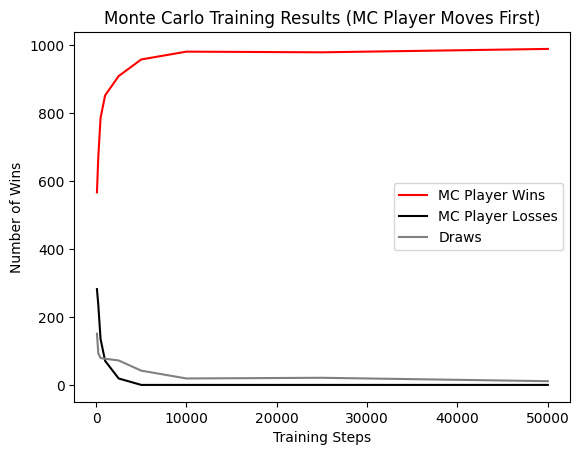

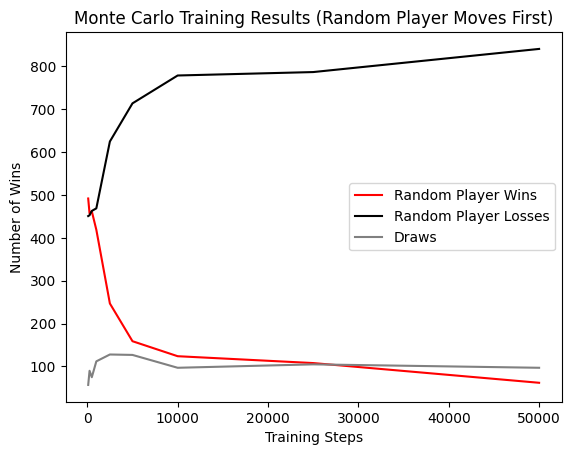

In [49]:
mc_player = MonteCarloPlayer()
opponent = RandomPlayer()  # or another MonteCarloPlayer

training_steps = [100, 250, 500, 1000, 2500, 5000, 10000, 25000, 50000]
training_results_move_first = []
training_results_move_second = []

previous_steps = 0

for steps in tqdm(training_steps):
    
    # 1. Train the RL-agent against the opponent for a given number of steps
    mc_player.train(opponent, steps - previous_steps)
    previous_steps = steps

    # 2. Play 1000 games against the opponent making the first move
    results = collect_results(mc_player, opponent, n_games=1000, verbose=False)
    training_results_move_first.append(results)

    # 3. Play 1000 games against the opponent making the second move
    results = collect_results(opponent, mc_player, n_games=1000, verbose=False)
    training_results_move_second.append(results)

# 4. Plot the results
def plot_results(training_results, move_first=True):
    plt.title(f"Monte Carlo Training Results ({'MC' if move_first else 'Random'} Player Moves First)")
    plt.plot(training_steps, [res['X'] for res in training_results], label=('MC' if move_first else 'Random') + ' Player Wins', color='red')
    plt.plot(training_steps, [res['O'] for res in training_results], label=('MC' if move_first else 'Random') + ' Player Losses', color='black')
    plt.plot(training_steps, [res['draw'] for res in training_results], label="Draws", color='gray')
    plt.legend()
    plt.xlabel("Training Steps")
    plt.ylabel("Number of Wins")
    plt.show()

plot_results(training_results_move_first, move_first=True)
plot_results(training_results_move_second, move_first=False)

In [50]:
# Print the length of the Q-values table
print(f"Number of Q-values: {len(mc_player.q_values)}")

Number of Q-values: 7839


In [52]:
#Play one single game against the opponent to see how the agent performs
new_game = TicTacToe()
play_game(new_game, mc_player, opponent, verbose=True)

Current player: X
⬜⬜⬜
⬜⬜⬜
⬜⬜⬜

Current player: O
⬜⬜⬜
⬜❌⬜
⬜⬜⬜

Current player: X
⬜⬜⬜
🔘❌⬜
⬜⬜⬜

Current player: O
❌⬜⬜
🔘❌⬜
⬜⬜⬜

Current player: X
❌⬜⬜
🔘❌⬜
⬜⬜🔘

Current player: O
❌❌⬜
🔘❌⬜
⬜⬜🔘

Current player: X
❌❌⬜
🔘❌⬜
⬜🔘🔘

Final board:
❌❌❌
🔘❌⬜
⬜🔘🔘

X wins!


'X'

### Integrating Symmetry Recognition 🪞

The game of Tic-Tac-Toe has a number of both **rotational and reflective symmetries** that can be exploited to reduce the number of states that need to be learned. In fact, a borad rotated or mirrored represents the `same strategic situation`. 

In considering this peculiaity, we can obtain:
1. **Reduced state space**: There are fewer unique states to learn.
2. **Faster Convergence**: The learning process can converge more quickly as it leverages knowledge gained from one state across its symmetrical equivalents.
3. **Improved Generalization**: The agent can generalize its knowledge to new states more effectively.

To implement this idea, I needed to:
1. **Identify symmetrical states** implementing a method to recognize when different board configurations are symmetrical equivalents.
2. **Consolidate learning across symmetrical states**: Once symmetrical states are identified, we need to treat them as a single state in the learning process.

Having said that, should we always attribute the same value to symmetrical states?
- `Theoretically, yes.` In a perfect information game like tic-tac-toe, symmetrically equivalent positions hold the same strategic value, as they lead to equivalent outcomes with optimal play.
- `Practically, maybe not.` Against an imperfect or asymmetrically playing opponent, there could be a strategic benefit to treating these positions differently, as it might exploit the opponent's lack of symmetry awareness.

#### DISCLAIMER ‼️
> I made several attempts to implement the second class, but encountered challenges in achieving proper functionality. Despite trying various approaches to implement symmetry recognition, I couldn't find a solution that worked consistently for all cases. Below is the code I've written for the class. If anyone has suggestions on how to improve it or identify the issues, I would greatly appreciate the assistance. 😔

In [87]:
from itertools import product

class SymmetryAwareMCPlayer(MonteCarloPlayer):

    def get_canonical_state(self, state):
        """Convert state to its canonical form."""
        board = np.array(state)
        transformations = [board]
        for _ in range(3):
            board = np.rot90(board)
            transformations.append(board)
            transformations.append(np.flipud(board))

        # Convert each transformation to a tuple for lexicographical comparison
        transformations = [tuple(map(tuple, trans)) for trans in transformations]

        return min(transformations)

    def find_transformation(self, original_state, canonical_state):
        """Find the transformation that transforms the original state to the canonical state."""
        original_board = np.array(original_state)
        canonical_board = np.array(canonical_state)

        # Define action transformation for rotation
        def rotate_action(action, times):
            for _ in range(times):
                action = (action[1], 2 - action[0])
            return action

        # Define action transformation for vertical flip
        def flip_action(action):
            return (2 - action[0], action[1])

        # 1. Check if original board is already in canonical form
        if np.array_equal(original_board, canonical_board):
            return lambda action: action  # No transformation needed

        # 2. Check rotations
        for i in range(1, 4):
            rotated = np.rot90(original_board, i)
            if np.array_equal(rotated, canonical_board):
                return lambda action, i=i: rotate_action(action, i)
        
        # 3. Check flip and rotations
        flipped = np.flipud(original_board)
        if np.array_equal(flipped, canonical_board):
            return flip_action
        for i in range(1, 4):
            rotated_flipped = np.rot90(flipped, i)
            if np.array_equal(rotated_flipped, canonical_board):
                # Combine flip and rotation
                return lambda action, i=i: rotate_action(flip_action(action), i)

        raise ValueError("No valid transformation found")

    def get_action(self, game: TicTacToe, training_phase=False):
        """Get a new action for the state balancing exploration and exploitation."""

        # 0. Get the current state representation
        original_state = self.get_hashable_state(game)
        canonical_state = self.get_canonical_state(original_state)
        #TODO: Remove
        #print(f"Original state: {original_state}")
        #print(f"Canonical state: {canonical_state}")

        # 1. Find the transformation that transforms the original state to the canonical state
        trans_to_canonical = self.find_transformation(original_state, canonical_state)
        trans_to_original = self.find_transformation(canonical_state, original_state)
        #TODO: Remove
        #print(f"Transformation o->c: {trans_to_canonical}")
        #print(f"Transformation c->o: {trans_to_original}")

        # 2. Get all possible actions
        empty_spaces = [(row, col) for row in range(3) for col in range(3) if game.board[row][col] == ' ']
        
        # 3. Explore: Choose a random action (only during training phase)
        if training_phase and random() < self.exploration_rate:
            return choice(empty_spaces)
        
        # 4. Exploit: Choose the action with the highest Q-value
        else:
            # 4.1. Transform the actions to the canonical state
            transformed_actions = [trans_to_canonical(action) for action in empty_spaces]

            # 4.2. Get the Q-values for each action
            q_values = [self.q_values.get((canonical_state, action), 0) for action in transformed_actions]

            # 4.3. Choose the action with the highest Q-value
            best_canonical_action = transformed_actions[np.argmax(q_values)]

            # 4.4. Transform the action back to the original state
            best_action = trans_to_original(best_canonical_action)

            #TODO: Remove
            #print(f"Best canonical action: {best_canonical_action}")
            #print(f"Best original action: {best_action}")
            return best_action


    def update_q_values(self, trajectory):
        """Update Q-values for canonical states and actions."""
        G = 0
        for state, action, reward in reversed(trajectory):
            canonical_state = self.get_canonical_state(state)
            trans_to_canonical = self.find_transformation(state, canonical_state)
            transformed_action = trans_to_canonical(action)
            G = self.discount_factor * G + reward

            if (canonical_state, transformed_action) not in self.q_values: 
                self.q_counters[(canonical_state, transformed_action)] = 0
                self.q_values[(canonical_state, transformed_action)] = 0.0

            self.q_counters[(canonical_state, transformed_action)] += 1
            self.q_values[(canonical_state, transformed_action)] += \
                self.learning_rate * (G - self.q_values[(canonical_state, transformed_action)]) / \
                self.q_counters[(canonical_state, transformed_action)]
            
    def get_action_reward(self, game: TicTacToe, action):
        """Get the reward for the given action in the given game state"""
        # A. Attribute a reward of -0.5 for each action to encourage the agent to win as fast as possible
        #reward = -0.5
        # B. Attribute a reward of 0 for each action that does not lead to a win
        reward = 0
        return reward